# Figure 2 in Hjorth et al, 2021 Neuroinformatics paper

This code can be run in parallel. To do that, please first start ```ipcluster```, on linux you write the following into the terminal, note that you should be in the same directory as the notebook is in (```examples/Neurinformatics2021/Figure2```):

```
export IPYTHONDIR="`pwd`/.ipython"
export IPYTHON_PROFILE=default
ipcluster start 
```

These commands are in ```start_ipcluster.sh``` in the ```examples/notebook``` directory. After starting ipcluster give it a few seconds to get fully up and running before proceeding with the rest of the commands in this notebook. 

If you restart the run you might need to do:

```
ipcluster stop
ipcluster start
```

For instructions how to install and activate ipyparallel for your notebook see 
https://github.com/ipython/ipyparallel

In [1]:
import os
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

Warning, running in serial.


In [12]:
from methods_paper_figure2 import MethodsPaperFigure2
from snudda import SnuddaPlace
from snudda import SnuddaDetect
from snudda import SnuddaPrune

network_type = ['No pruning',
                'DP',
                'DP, f1',
                'DP, f1, SM',
                'DP, f1, SM, mu2']

network_size = 10000
network_path = "Fig2_network"
config_list = []
network_file_list = []

for idx, nt in enumerate(network_type):
    config_name = os.path.join(f"network-config-{idx}.json")
    config_list.append(config_name)
    network_file = os.path.join(network_path, f"network-synapses-{idx}.hdf5")
    network_file_list.append(network_file)

In [3]:
for config_name, nt in zip(config_list, network_type):
    MethodsPaperFigure2.setup_network(network_path=network_path, config_name=config_name,
                                      network_type=nt, n_neurons=network_size, random_seed=1234)

Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing Fig2_network/network-config-0.json
Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing Fig2_network/network-config-1.json
Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing Fig2_network/network-config-2.json
Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing Fig2_network/network-config-3.json
Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing Fig2_network/network-config-4.json
Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Add

In [4]:
conf_file=os.path.join(network_path, config_list[-1])

sp = SnuddaPlace(config_file=conf_file, rc=rc)
sp.place()
    
sd = SnuddaDetect(config_file=conf_file, rc=rc)
sd.detect()

No d_view specified, running distribute neurons in serial
Processing hyper voxel : 31/125 (1000 neurons)
Processing hyper voxel : 56/125 (888 neurons)
Processing hyper voxel : 36/125 (775 neurons)
Processing hyper voxel : 32/125 (727 neurons)
Processing hyper voxel : 30/125 (618 neurons)
Processing hyper voxel : 26/125 (574 neurons)
Processing hyper voxel : 61/125 (513 neurons)
Processing hyper voxel : 57/125 (460 neurons)
Processing hyper voxel : 6/125 (440 neurons)
Processing hyper voxel : 37/125 (381 neurons)
Processing hyper voxel : 55/125 (374 neurons)
Processing hyper voxel : 51/125 (344 neurons)
Processing hyper voxel : 35/125 (273 neurons)
Processing hyper voxel : 27/125 (215 neurons)
Processing hyper voxel : 62/125 (208 neurons)
Processing hyper voxel : 11/125 (184 neurons)
Processing hyper voxel : 25/125 (167 neurons)
Processing hyper voxel : 7/125 (157 neurons)
Processing hyper voxel : 60/125 (130 neurons)
Processing hyper voxel : 5/125 (119 neurons)
Processing hyper voxel :

In [13]:
network_file = os.path.join(network_path, "network-synapses.hdf5")
    
for config_name, new_network_file in zip(config_list, network_file_list):
    config_file = os.path.join(network_path, config_name)
    sp2 = SnuddaPrune(network_path=network_path, config_file=config_file, rc=rc, keep_files=True)
    sp2.prune()
    
    # We need to save the network files with new names for each pruning
    os.rename(network_file, new_network_file)

Worker synapses: 11/5605223 (heap size: 24)
Worker synapses: 5605223/5605223 (heap size: 0)
Read 5605223 out of total 5605223 synapses


Loading Fig2_network/network-synapses-0.hdf5
Assuming volume type: cube[cube or full]
Only using 20000neurons of the connection data
Loading 1000 neurons with 2028088 synapses and 0 gap junctions
Number of neurons: 1000
Synapse row 0 - 0.0 % time: 0.08970462599972961 seconds
Synapse row 1000000 - 49.30752511725329 % time: 0.772011263999957 seconds
Synapse row 1514044 - 74.65376255862665 % time: 1.1668020010001783 seconds
Created connection matrix 1.552158311000312 seconds
Created gap junction connection matrix 0.0005210219987930031 seconds
Creating population dictionary
Done.
!!! Setting sideLen to None
Calculating synapse distance histogram
Creating dist histogram
nSynapses = 2028088, at 0
nSynapses = 2028088, at 1000000
nSynapses = 2028088, at 2000000
Created distance histogram (optimised) in 2.344350478000706 seconds
Saving cache to Fig2_network/network-synapses-0.hdf5-cache
Loading Fig2_network/network-synapses-1.hdf5
Assuming volume type: cube[cube or full]
Only using 20000neurons

/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [128372.]
Rejected (too large z-depth): 121628
Centering in Striatum : Keeping 500/500
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [128372.]
Rejected (too large z-depth): 121628
Centering in Striatum : Keeping 500/500
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [128372.]
Rejected (too large z-depth): 121628
Centering in Striatum : Keeping 500/500
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [128372.]
Rejected (too large z-depth): 121628
Centering in Striatum : Keeping 500/500
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [128372.]
Rejected (too large z-depth): 121628
Centering in Striatum : Keeping 500/500
Counting connections
Requested: 10000000.0 calculated [128372.]
Rejected (too large z-depth): 121628


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


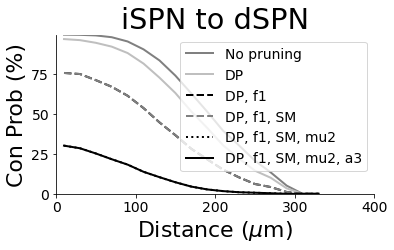

Wrote Fig2_network/figures/Summary-pruning-dist-dep-connection-probability-iSPN-to-dSPN-synapses.png
Centering in Striatum : Keeping 500/500
Calculating max synapses
Plotting 176726 connections
Centering in Striatum : Keeping 500/500
Calculating max synapses
Plotting 154400 connections
Centering in Striatum : Keeping 500/500
Calculating max synapses
Plotting 97541 connections
Centering in Striatum : Keeping 500/500
Calculating max synapses
Plotting 97541 connections
Centering in Striatum : Keeping 500/500
Calculating max synapses
Plotting 24610 connections
Centering in Striatum : Keeping 500/500
Calculating max synapses
Plotting 24610 connections


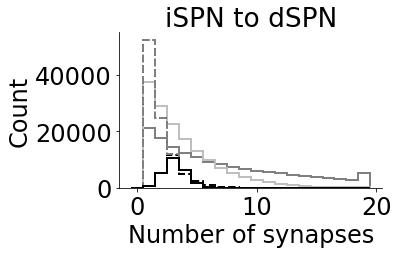

Wrote Fig2_network/figures/Summary-network-number-of-synapses-from-iSPN-to-dSPN-per-cell.png


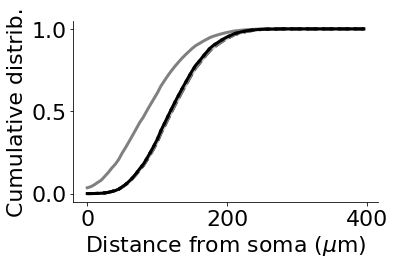

Wrote Fig2_network/figures/Summary-cumDist-of-synapses-from-iSPN-to-dSPN-per-cell.png


In [14]:
mpf = MethodsPaperFigure2(network_file_list=network_file_list)
mpf.make_connection_probability_summary('iSPN', 'dSPN')
mpf.make_num_synapses_summary_figure('iSPN', 'dSPN')
mpf.summary_plot_cum_dist('iSPN', 'dSPN')

['network-config-0.json',
 'network-config-1.json',
 'network-config-2.json',
 'network-config-3.json',
 'network-config-4.json',
 'network-config-5.json']